# Deep Learning: Assignment #3
## Submission date: 07/01/2026, 23:59.
### Topics:
- RNNs
- GRUs
- LSTMs
- Transformers


**Submitted by:**

- **Student 1 — Mahmoud Abade, 206773756**
- **Student 2 — Firas Dwere, 214225021**


**Assignment Instructions:**

· Submissions are in **pairs only**. Write both names + IDs at the top of the notebook.

· Keep your code **clean, concise, and readable**.

· You may work in your IDE, but you **must** paste the final code back into the **matching notebook cells** and run it there.  


· <font color='red'>Write your textual answers in red.</font>  
(e.g., `<span style="color:red">your answer here</span>`)

· All figures, printed results, and outputs should remain visible in the notebook.  
Run **all cells** before submitting and **do not clear outputs**.

· Use relative paths — **no absolute file paths** pointing to local machines.

· **Important:** Your submission must be entirely your own.  
Any form of plagiarism (including uncredited use of ChatGPT or AI tools) will result in **grade 0** and disciplinary action.


## Question 1 — Chatbot Tutorial (35 Points)

In this tutorial, we explore a classical and instructive application of
**recurrent sequence-to-sequence (seq2seq) models**: building a neural
chatbot. Chatbots provide a natural and intuitive testbed for studying
sequence models, as they require processing variable-length input
sequences and generating coherent variable-length outputs, one token at
a time.

Conversational agents are a long-standing and active research topic in
artificial intelligence. Chatbots appear in a wide range of practical
settings, including customer service systems, online helpdesks, and
virtual assistants. Many deployed systems rely on **retrieval-based
models**, which select responses from a predefined set based on the input
query. While such approaches can be effective in narrowly defined
domains, they lack the flexibility required for open-domain
conversation.

Teaching a machine to generate meaningful, context-aware responses
across multiple domains remains a challenging and largely unsolved
problem. The rise of deep learning has enabled a class of **generative
conversational models**, most notably the *Neural Conversational Model*
introduced by Vinyals and Le (2015), which demonstrated that an
encoder–decoder architecture can be trained end-to-end to map input
sentences directly to output sentences.

Inspired by this line of work, we study a simplified generative chatbot
implemented using modern deep learning tools.

In this question, we will work with conversational data extracted from
movie scripts in the
[Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html).
Each training example consists of an input sentence and a corresponding
response sentence, forming a paired sequence-to-sequence learning task.


### Load & Preprocess Data

To start, we load the data. Download the data ZIP file
[here](https://zissou.infosci.cornell.edu/convokit/datasets/movie-corpus/movie-corpus.zip) and unzip it in the current directory, or alternalively run the following cell:


In [22]:
!mkdir data
!cd data
!wget https://zissou.infosci.cornell.edu/convokit/datasets/movie-corpus/movie-corpus.zip
!unzip -q movie-corpus.zip
!cd ..

--2026-01-15 17:57:35--  https://zissou.infosci.cornell.edu/convokit/datasets/movie-corpus/movie-corpus.zip
Resolving zissou.infosci.cornell.edu (zissou.infosci.cornell.edu)... 128.253.51.179
Connecting to zissou.infosci.cornell.edu (zissou.infosci.cornell.edu)|128.253.51.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40854701 (39M) [application/zip]
Saving to: ‘movie-corpus.zip’

movie-corpus.zip    100%[===================>]  38.96M  19.2MB/s    in 2.0s    

2026-01-15 17:57:37 (19.2 MB/s) - ‘movie-corpus.zip’ saved [40854701/40854701]



After loading the data, let’s import some necessities.

In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

The next step is to reformat our data file and load the data into
structures that we can work with.

The [Cornell Movie-Dialogs
Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)_
is a rich dataset of movie character dialog:

-  220,579 conversational exchanges between 10,292 pairs of movie
   characters
-  9,035 characters from 617 movies
-  304,713 total utterances

This dataset is large and diverse, and there is a great variation of
language formality, time periods, sentiment, etc. Our hope is that this
diversity makes our model robust to many forms of inputs and queries.

First, we’ll take a look at some lines of our datafile to see the
original format.




In [24]:
!ls data

In [25]:
corpus = "movie-corpus"
corpus_name = "movie-corpus"

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

#### Create formatted data file

For convenience, we'll create a nicely formatted data file in which each line contains a tab-separated *query sentence* and a *response sentence* pair.

The following functions facilitate the parsing of the raw
*utterances.jsonl* data file.


In the next cell, you'll find the functions:
-  ``loadLinesAndConversations`` splits each line of the file into a dictionary of lines with fields: lineID, characterID, and text and then groups them into conversations with fields: conversationID, movieID, and lines.

-  ``extractSentencePairs`` extracts pairs of sentences from
   conversations.


> Run the code in the next cell.

In [26]:
# Splits each line of the file to create lines and conversations
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            # Extract fields for line object
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            # Extract fields for conversation object
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

Now we’ll call these functions and create the file. We’ll call it
*formatted_movie_lines.txt*.




In [27]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict and conversations dict
lines = {}
conversations = {}
# Load lines and conversations
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


#### Trim Data

We now move from raw text to a representation that a neural network can process.
Our next task is to build a **vocabulary** and load the **query/response pairs**
into memory.

Unlike images, text does not come with an inherent mapping to a numerical space.
A sequence model expects **integer token indices**, so we must define a mapping
from each unique word in the dataset to a discrete index.

To do this, we define a `Voc` (vocabulary) class that maintains:

- `word2index`: a mapping from each word to an integer index  
- `index2word`: the inverse mapping from indices back to words  
- `word2count`: a frequency table used for trimming rare words  
- `num_words`: the current vocabulary size  

In addition, we reserve a small set of **special tokens**:

- `PAD` for padding shorter sequences in a batch  
- `SOS` to mark the start of a sequence for the decoder  
- `EOS` to mark the end of a sequence  
- `UNK` to represent words that are not in the vocabulary  

Later, we will remove infrequent words from the vocabulary using a minimum
frequency threshold (`MIN_COUNT`). This reduces noise and decreases the effective
problem size, which often improves training stability and convergence.


In [28]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
UNK_token = 3  # Unknown word token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {
            PAD_token: "PAD",
            SOS_token: "SOS",
            EOS_token: "EOS",
            UNK_token: "UNK",
        }
        self.num_words = 4  # Count default tokens

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {
            PAD_token: "PAD",
            SOS_token: "SOS",
            EOS_token: "EOS",
            UNK_token: "UNK",
        }
        self.num_words = 4  # Count default tokens

        for word in keep_words:
            self.addWord(word)


We begin by converting Unicode strings to ASCII using `unicodeToAscii`.
Next, all text is lowercased and non-letter characters are removed while
preserving basic punctuation (`normalizeString`).
Finally, to promote stable training and reduce unnecessary computation,
we filter out sentence pairs whose length exceeds the `MAX_LENGTH`
threshold (`filterPairs`).


In [29]:
MAX_LENGTH = 10  # Maximum sentence length to consider

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

def readVocs(datafile, corpus_name):
    print("Reading lines...")
    lines = open(datafile, encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)

print("\nSample pairs:")
for pair in pairs[:10]:
    print(pair)


Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64313 sentence pairs
Counting words...
Counted words: 18083

Sample pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


Another technique that often improves training efficiency is **trimming
rarely used words** from the vocabulary. Intuitively, words that appear
only a handful of times contribute little to the learning signal, while
significantly increasing the size of the vocabulary.

We perform trimming as a two-step process:

1. Remove words that appear fewer than `MIN_COUNT` times from the
   vocabulary.
2. Remove sentence pairs that contain any of the trimmed words, ensuring
   that all remaining training examples are fully represented in the
   vocabulary.

This procedure reduces noise, lowers the dimensionality of the problem,
and often leads to faster and more stable convergence during training.


In [30]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(
        len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)
    ))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)


keep_words 7833 / 18079 = 0.4333
Trimmed from 64313 pairs to 53131, 0.8261 of total


### Preparing Data for the Model



So far, we have transformed raw conversational text into a cleaned and
trimmed set of *(input, response)* sentence pairs, along with a vocabulary
that maps words to integer indices.

However, neural sequence models do not operate directly on text. Instead,
they expect **numerical tensors** as input. In this section, we convert
our sentence pairs into padded tensors that can be efficiently processed
by the encoder–decoder model.

To accelerate training and make effective use of GPU parallelism, we will
train the model using **mini-batches** rather than individual sentence
pairs. This introduces an additional challenge: sentences within a batch
may have different lengths.

To handle variable-length sequences, we adopt the following conventions:

- Sentences are converted to sequences of word indices and terminated
  with an `EOS_token`.
- All sequences in a batch are padded to the length of the longest
  sequence using the `PAD_token`.
- Batched input tensors are shaped as  
  **(max_sequence_length, batch_size)**,  
  so that each time step can be processed across all sequences in parallel.

This layout is particularly convenient for recurrent models, which
process input one time step at a time.


In addition to the padded input and target tensors, we also construct:

- A **lengths tensor**, which stores the true (unpadded) length of each
  input sequence. This will later be used to efficiently process variable-
  length sequences.
- A **binary mask tensor** for the target sequences, where padded positions
  are marked with 0 and valid tokens with 1. This allows us to ignore padded
  values when computing the training loss.

The following helper functions implement this batching pipeline.


In [31]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index.get(word, UNK_token) for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))


def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m


# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths


# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max(len(indexes) for indexes in indexes_batch)
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len


# Returns all items for a given batch of sentence pairs
def batch2TrainData(voc, pair_batch):
    # Sort pairs by input sentence length (descending)
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)

    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])

    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


### Model Architecture



#### Sequence-to-Sequence Architecture

The core of our chatbot is a **sequence-to-sequence (seq2seq)** model.
The objective of a seq2seq model is to map a variable-length input
sequence to a variable-length output sequence using a fixed-size neural
network.

[Sutskever et al. (2014)](https://arxiv.org/abs/1409.3215) demonstrated
that this task can be accomplished by composing two recurrent neural
networks:

- An **encoder**, which processes the input sequence and compresses it
  into an internal representation.
- A **decoder**, which generates the output sequence one token at a time,
  conditioned on the encoder’s representation.

In the context of conversational modeling, the encoder reads the input
sentence (the query), and the decoder generates the response.

This encoder–decoder formulation underlies many modern sequence modeling
approaches in machine translation, dialogue systems, and text
generation.


#### Encoder

In this part, you will implement the **encoder** component of the
sequence-to-sequence model.

The encoder processes the input sentence one token (word) at a time.
At each time step, it produces an output vector and updates an internal
**hidden state** that summarizes the sequence observed so far.

You should implement the encoder using a **multi-layer Gated Recurrent
Unit (GRU)**, introduced by [Cho et al. (2014)](https://arxiv.org/pdf/1406.1078v3.pdf).
GRUs extend standard recurrent neural networks by incorporating gating
mechanisms that regulate information flow, enabling more effective
modeling of long-term dependencies.

Your encoder should be **bidirectional**, meaning that the input sequence is processed both forward and backward in time. The outputs of the forward and backward GRUs should be **summed** at each time step to form the final encoder output representation.

Before being passed to the GRU, word indices are mapped into a continuous vector space using an **embedding layer**, which is provided to the encoder. The embedding dimension is equal to the GRU hidden size.

When processing padded mini-batches, you must correctly pack and unpack
sequences using:

- `nn.utils.rnn.pack_padded_sequence`
- `nn.utils.rnn.pad_packed_sequence`

This ensures that the GRU does not perform unnecessary computation over
padding tokens.


**Encoder Inputs**

- `input_seq`: Padded batch of input sentences  
  Shape: *(max_length, batch_size)*

- `input_lengths`: True lengths of each sentence in the batch  
  Shape: *(batch_size)*

**Encoder Outputs**

- `outputs`: Output features from the last hidden layer of the GRU  
  (sum of bidirectional outputs)  
  Shape: *(max_length, batch_size, hidden_size)*

- `hidden`: Final hidden state of the GRU  
  Shape: *(n_layers × num_directions, batch_size, hidden_size)*


In [32]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

#### Decoder with Attention

The decoder generates the response sequence in a token-by-token manner.
At each time step, it predicts the next word based on:

- its current hidden state,
- the previously generated word, and
- a **context vector** computed from the encoder outputs.

A limitation of vanilla seq2seq models is their reliance on a single
fixed-length context vector to represent the entire input sequence.
This bottleneck becomes particularly problematic for long input
sentences.

To address this issue, [Bahdanau et al. (2015)](https://arxiv.org/abs/1409.0473) introduced the **attention mechanism**, which allows the decoder to focus on different parts of the input sequence at each decoding step.

[Luong et al. (2015)](https://arxiv.org/abs/1508.04025) later proposed
**Global Attention**, in which the decoder attends to *all* encoder
hidden states at every time step. Attention weights are computed using
the decoder’s current hidden state and the encoder outputs via a
parameterized **score function**.

In this assignment, you will implement Luong-style global attention., which computes a soft alignment between the decoder state and the encoder outputs, producing a context vector that guides each decoding step.


At a given decoding step $t$, the attention mechanism computes an
alignment score between the current decoder hidden state $h_t$ and each encoder output $\bar{h_s}$.

Luong attention defines three possible **score functions**:

- **Dot**:  
  $\text{score}(h_t, \bar{h}_s) = h_t^\top \bar{h}_s$

- **General**:  
  $\text{score}(h_t, \bar{h}_s) = h_t^\top W \bar{h}_s$

- **Concat**:  
  $\text{score}(h_t, \bar{h}_s) = v^\top \tanh(W [h_t ; \bar{h}_s])$

The attention weights are obtained by applying a softmax over all encoder time steps. These weights are then used to compute a **context vector** as a weighted sum of encoder outputs.


In [33]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def forward(self, hidden, encoder_outputs):
        # hidden: (1, batch, hidden_size)
        # encoder_outputs: (max_length, batch, hidden_size)

        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = torch.zeros(this_batch_size, max_len, device=device) # (B, S)

        # Vectorized implementation
        encoder_outputs_t = encoder_outputs.transpose(0, 1) # (B, S, H)
        hidden_s = hidden[-1] # (B, H)

        if self.method == 'dot':
             # (B, 1, H) . (B, H, S) -> (B, 1, S)
             attn_energies = torch.bmm(hidden_s.unsqueeze(1), encoder_outputs_t.transpose(1, 2)).squeeze(1)
        elif self.method == 'general':
             energy = self.attn(encoder_outputs_t) # (B, S, H)
             attn_energies = torch.bmm(hidden_s.unsqueeze(1), energy.transpose(1, 2)).squeeze(1)
        elif self.method == 'concat':
             # Expand hidden_s to (B, S, H)
             hidden_ext = hidden_s.unsqueeze(1).expand(-1, max_len, -1)
             combined = torch.cat((hidden_ext, encoder_outputs_t), 2) # (B, S, 2H)
             energy = torch.tanh(self.attn(combined)) # (B, S, H)
             v = self.v.unsqueeze(0).expand(this_batch_size, 1, -1)
             attn_energies = torch.sum(v * energy, dim=2)

        return F.softmax(attn_energies, dim=1).unsqueeze(1) # (B, 1, S)

#### Decoder with Luong Attention

We now define the decoder. Unlike the encoder (which processes the entire input
sequence in one forward pass), the decoder is executed **one time step at a time**:
at each step it receives a single token and produces a probability distribution
over the vocabulary for the next token.

Concretely, at decoding step $t$:

- The input to the decoder is a tensor `input_step` of shape **(1, batch_size)**,
  containing one token per sequence.
- After embedding, this becomes **(1, batch_size, hidden_size)**.
- The decoder updates its hidden state using a unidirectional GRU.

A standard seq2seq decoder compresses the entire input into a fixed vector, which can lead to information loss—especially for longer sequences. To address this, we incorporate an **attention mechanism**.


We use **Luong et al. (2015)** global attention:
[Luong et al., 2015](https://arxiv.org/abs/1508.04025).
At each decoding step, the decoder computes attention weights over all encoder time steps, then uses these weights to form a context vector (a weighted sum of encoder outputs). This context vector summarizes the parts of the input sentence that are most relevant for predicting the next word.


At each decoding step, the decoder should:

1. Embed the current input token.
2. Run one GRU step to update the decoder hidden state.
3. Compute attention weights using the current decoder state and encoder outputs.
4. Use the attention weights to compute a context vector.
5. Combine the decoder state and context vector.
6. Predict a probability distribution over the vocabulary.

You are asked to implement both the **initialization** and **forward pass** of the Luong attention decoder according to this description.

---

**Inputs**

- `input_step`: one time step (one token) for each sequence in the batch  
  Shape: **(1, batch_size)**

- `last_hidden`: previous decoder hidden state  
  Shape: **(n_layers, batch_size, hidden_size)**

- `encoder_outputs`: encoder outputs for all time steps  
  Shape: **(max_length, batch_size, hidden_size)**

**Outputs**

- `output`: probability distribution over the vocabulary for the next token  
  Shape: **(batch_size, voc.num_words)**

- `hidden`: updated decoder hidden state  
  Shape: **(n_layers, batch_size, hidden_size)**


In [34]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # input_step: (1, B)
        # last_hidden: (n_layers, B, H)
        # encoder_outputs: (S, B, H)

        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)

        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # rnn_output: (1, B, H)

        # Calculate attention weights
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # attn_weights: (B, 1, S)

        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # context: (B, 1, H)

        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))

        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)

        return output, hidden

### Define Training Procedure





We now define the components required to train our seq2seq chatbot.
Training is performed over mini-batches of padded sequences, which
requires special care when computing the loss and updating model
parameters.

#### Masked Loss

Because batches contain padded sequences, not all positions in the target
tensor correspond to valid words. We therefore compute the loss only over
non-padding positions.

The function below computes a **masked negative log-likelihood loss**,
given the decoder’s output distribution, the target tokens, and a binary
mask that indicates which positions are valid (i.e., not `PAD_token`).


In [35]:
def maskNLLLoss(inp, target, mask):
    """
    inp:    (batch_size, vocab_size) softmax probabilities
    target: (batch_size,) target token indices
    mask:   (batch_size,) boolean mask (True for valid tokens, False for PAD)
    """
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

#### Single Training Iteration

We now describe a **single training iteration**, corresponding to one
mini-batch update.

During each iteration, we apply two commonly used techniques to improve
training stability and convergence:

- **Teacher forcing**: with some probability, the decoder receives the
  ground-truth token as its next input instead of its own prediction.
  This can significantly speed up training, but excessive teacher
  forcing may lead to poor performance at inference time.

- **Gradient clipping**: gradients are clipped to a maximum norm to
  prevent the exploding gradient problem, which is particularly common
  in recurrent neural networks.

The sequence of operations for a single iteration is as follows:


#### Single Training Iteration (Implement)

In this part you will implement a **single mini-batch update** for the
seq2seq chatbot.

You must handle two key ideas we covered in class:

- **Teacher forcing**: with some probability, `teacher_forcing_ratio`, feed the ground-truth token as the next decoder input; otherwise, feed the model’s own prediction.
- **Gradient clipping**: clip gradient norms to avoid exploding gradients in RNN training.

Your implementation should follow this high-level sequence:



**Sequence of Operations**

1. Forward pass the input batch through the encoder.
2. Initialize the decoder input with `SOS_token` and the decoder hidden
   state with the encoder’s final hidden state.
3. Decode one time step at a time:
   - apply teacher forcing with probability `teacher_forcing_ratio`
   - otherwise, feed the decoder’s own prediction as the next input
4. Compute and accumulate masked loss.
5. Backpropagate gradients.
6. Clip gradients.


Complete the function `train(...)` so that it performs one full mini-batch training update according to the sequence of operations described abov

In [36]:
def train(input_variable, lengths, target_variable, mask, max_target_len,
          encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer,
          batch_size, clip, max_length=MAX_LENGTH):
    """
    Performs a single mini-batch update step.

    Inputs:
        input_variable:  (max_input_len, batch_size)
        lengths:         (batch_size,)  (must be on CPU for packing)
        target_variable: (max_target_len, batch_size)
        mask:            (max_target_len, batch_size) boolean
        max_target_len:  int

    Returns:
        avg_loss: average masked loss per non-PAD token (float)
    """

    # Move tensors to the correct device
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    lengths = lengths.to("cpu")  # required by pack_padded_sequence


    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]]).to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    loss = 0
    print_losses = []
    n_totals = 0

    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_input = target_variable[t].view(1, -1)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]]).to(device)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    loss.backward()

    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    # Return average loss per non-pad token
    return sum(print_losses) / n_totals

#### Training Loop

We now wrap the single training iteration into a full training loop.
At each iteration, a random mini-batch is sampled and one parameter
update is performed.

We periodically print training statistics and save model checkpoints,
which include the encoder and decoder parameters, optimizer states, and
vocabulary information.


In [37]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
               embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration,
               batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    training_batches = [
        batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
        for _ in range(n_iteration)
    ]

    print('Initializing ...')
    start_iteration = 1
    print_loss = 0

    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        input_variable, lengths, target_variable, mask, max_target_len = training_batches[iteration - 1]

        loss = train(input_variable, lengths, target_variable, mask, max_target_len,
                     encoder, decoder, embedding,
                     encoder_optimizer, decoder_optimizer,
                     batch_size, clip)

        print_loss += loss

        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print(f"Iteration: {iteration}; Percent complete: {iteration / n_iteration * 100:.1f}%; Average loss: {print_loss_avg:.4f}")
            print_loss = 0

        if iteration % save_every == 0:
            directory = os.path.join(
                save_dir, model_name, corpus_name,
                f'{encoder_n_layers}-{decoder_n_layers}_{hidden_size}'
            )
            os.makedirs(directory, exist_ok=True)

            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, f'{iteration}_checkpoint.tar'))


### Model Evaluation


After training the chatbot model, we would like to interact with it and
generate responses to user-provided input sentences. To do so, we must
define how the decoder generates an output sequence from the encoded
input.

During training, the decoder may receive ground-truth tokens as input
(teacher forcing). During evaluation, however, the model must rely
entirely on its own predictions. This requires defining an explicit
**decoding strategy**.

#### Greedy Decoding

We use **greedy decoding** to generate responses at evaluation time.
At each decoding step, greedy decoding selects the word with the highest predicted probability from the decoder’s output distribution.

Formally, given the decoder output distribution at time step $t$,
greedy decoding chooses:

$$
\hat{w}_t = \arg\max_w \; p(w \mid w_{<t}, x)
$$

Greedy decoding is optimal at the level of individual time steps, though it does not guarantee a globally optimal sequence. Despite this
limitation, it is simple, efficient, and serves as a strong baseline for sequence generation.


To implement greedy decoding, we define a `GreedySearchDecoder` module.
This module wraps the encoder and decoder and performs decoding one time step at a time.

Given an input sentence, decoding proceeds as follows:

**Computation Graph**

1. Forward the input sequence through the encoder.
2. Initialize the decoder hidden state using the encoder’s final hidden state.
3. Initialize the decoder input with the `SOS_token`.
4. Iteratively decode one token at a time:
   - Forward pass through the decoder.
   - Select the most probable token.
   - Feed the selected token as input to the next step.
5. Collect and return the generated tokens and their scores.


In [38]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

#### Evaluating Text Input

With the decoding procedure defined, we can now evaluate individual input sentences.

The `evaluate` function handles the low-level mechanics of evaluation:
it converts an input sentence into a tensor of word indices, prepares the appropriate length tensor, and runs greedy decoding to obtain the outputn sequence.

The `evaluateInput` function provides a simple interactive interface for the chatbot. It repeatedly prompts the user for input, normalizes the sentence using the same preprocessing pipeline as the training data, and prints the decoded response. The interaction continues until the user enters `"q"` or `"quit"`.


In [39]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    """
    Evaluate a single input sentence using greedy decoding.
    Out-of-vocabulary words are mapped to UNK_token.
    """
    # words -> indexes (UNK-safe)
    indexes = [
        voc.word2index.get(word, UNK_token)
        for word in sentence.split(' ')
    ] + [EOS_token]

    indexes_batch = [indexes]

    # Create lengths tensor
    lengths = torch.tensor([len(indexes)])

    # Prepare input batch (max_length, batch_size=1)
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")

    # Decode sentence
    tokens, scores = searcher(input_batch, lengths, max_length)

    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    """
    Interactive chatbot interface.
    Type 'q' or 'quit' to exit.
    """
    while True:
        # Get input sentence
        input_sentence = input('> ')
        if input_sentence in ('q', 'quit'):
            break

        # Normalize input
        input_sentence = normalizeString(input_sentence)

        # Evaluate sentence
        output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)

        # Remove EOS and PAD tokens from output
        output_words = [w for w in output_words if w not in ('EOS', 'PAD')]

        print('Bot:', ' '.join(output_words))


### Run Model

Finally, it is time to run our model!

Regardless of whether we want to train or test the chatbot model, we
must initialize the individual encoder and decoder models. In the
following block, we set our desired configurations, choose to start from scratch or set a checkpoint to load from, and build and initialize the models. Feel free to play with different model configurations to
optimize performance.

In [40]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


#### Run Training

Run the following block in order to train the model.

First we set training parameters, then we initialize our optimizers, and finally we call the ``trainIters`` function to run our training
iterations.

In [41]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9806
Iteration: 2; Percent complete: 0.1%; Average loss: 8.8439
Iteration: 3; Percent complete: 0.1%; Average loss: 8.6347
Iteration: 4; Percent complete: 0.1%; Average loss: 8.3691
Iteration: 5; Percent complete: 0.1%; Average loss: 7.8546
Iteration: 6; Percent complete: 0.1%; Average loss: 7.5188
Iteration: 7; Percent complete: 0.2%; Average loss: 6.8787
Iteration: 8; Percent complete: 0.2%; Average loss: 6.8319
Iteration: 9; Percent complete: 0.2%; Average loss: 6.5337
Iteration: 10; Percent complete: 0.2%; Average loss: 6.6717
Iteration: 11; Percent complete: 0.3%; Average loss: 6.0717
Iteration: 12; Percent complete: 0.3%; Average loss: 5.7660
Iteration: 13; Percent complete: 0.3%; Average loss: 5.6226
Iteration: 14; Percent complete: 0.4%; Average loss: 5.3849
Iteration: 15; Percent complete: 0.4%; Average loss: 5.7293
Iteration: 16; Percent complete: 0.4%

#### Run Evaluation

To chat with your model, run the following block.

In [42]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting by uncommenting the line:
evaluateInput(encoder, decoder, searcher, voc)

> hi
Bot: hi . . . . .
> hello
Bot: hello . . . . .
> how are you?
Bot: fine . . . . .
> where do you live?
Bot: i don t know . . .
> what is your name?
Bot: i don t know . . !
> how old are you?
Bot: i m fine . . . .
> what is your favourite colour?
Bot: it s a trifle idea . . .
> where are you going?
Bot: to the hilton . . . .
> what are you going to do tomorrow?
Bot: i m going to see you . .
> bye
Bot: bye . . . . .
> q


### Beam Search Decoding


So far, we used **greedy decoding**, which selects the most likely next token at each step.
Greedy decoding is fast, but it may miss better full sequences because it commits to local choices.

In this task you will implement **beam search**, as discussed in class.
Beam search keeps the top-*k* partial hypotheses at each decoding step, ranked by their cumulative log-probability.

**Requirements**
- Implement `BeamSearchDecoder` similar in interface to `GreedySearchDecoder`.
- Use beam width `k` (beam size) as a configurable argument.
- Use **log-probabilities** (sum of log-probs) to score sequences.
- Stop a hypothesis when it emits `EOS_token` (you may keep completed hypotheses in a separate list).
- Return the best decoded token sequence (and optionally its scores).

In [43]:
class BeamSearchDecoder(nn.Module):
    def __init__(self, encoder, decoder, beam_size=5):
        super(BeamSearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beam_size = beam_size

    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]

        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token

        # Beam structure: list of (cumulative_score, list_of_tokens, decoder_hidden)
        # Note: list_of_tokens includes all tokens including SOS.
        # But for output we should match greedy searcher which returns tokens and scores.

        candidates = [(0.0, [SOS_token], decoder_hidden)]
        completed_sequences = []

        for _ in range(max_length):
            new_candidates = []
            for score, seq, hidden in candidates:
                # If last token is EOS, it's completed
                if seq[-1] == EOS_token:
                    completed_sequences.append((score, seq, hidden))
                    continue

                dec_input = torch.LongTensor([[seq[-1]]]).to(device)
                decoder_output, next_hidden = self.decoder(dec_input, hidden, encoder_outputs)

                # Get log probabilities
                log_probs = torch.log(decoder_output).squeeze(0) # (Vocab)
                topv, topi = log_probs.topk(self.beam_size)

                for v, i in zip(topv, topi):
                    new_score = score + v.item()
                    new_seq = seq + [i.item()]
                    new_candidates.append((new_score, new_seq, next_hidden))

            # If all candidates completed, break
            if len(new_candidates) == 0:
                break

            # Sort and prune
            new_candidates.sort(key=lambda x: x[0], reverse=True)
            candidates = new_candidates[:self.beam_size]

        # Add any remaining candidates to completed (in case max_length reached)
        completed_sequences.extend(candidates)
        completed_sequences.sort(key=lambda x: x[0], reverse=True)

        best_seq = completed_sequences[0][1]

        # Remove SOS for result tokens
        tokens = torch.tensor(best_seq[1:], device=device, dtype=torch.long)
        # Dummy scores to match the return signature of GreedySearchDecoder (all_tokens, all_scores)
        scores = torch.zeros(len(tokens), device=device)

        return tokens, scores

Run the following cell and try the **same 10 prompts** with greedy vs. beam search.
Briefly comment: do you observe differences? When might beam search help, and when might it hurt?


In [45]:
greedy_searcher = GreedySearchDecoder(encoder, decoder)
beam_searcher = BeamSearchDecoder(encoder, decoder)

evaluateInput(encoder, decoder, greedy_searcher, voc)
evaluateInput(encoder, decoder, beam_searcher, voc)

> hi
Bot: hi . . . . .
> hello
Bot: hello . . . . .
> how are you?
Bot: fine . . . . .
> where do you live?
Bot: i don t know . . .
> what is your name?
Bot: i don t know . . !
> how old are you?
Bot: i m fine . . . .
> what is your favorite color?
Bot: i don t know . . .
> where are you going?
Bot: to the hilton . . . .
> what are you going to do tomorrow?
Bot: i m going to see you . .
> bye
Bot: bye . . . . .
> q
> hi
Bot: hi .
> hello
Bot: hello .
> how are you?
Bot: fine .
> where do you live?
Bot: i don t know .
> what is your name?
Bot: gretchen .
> how old are you?
Bot: fine .
> what is your favorite color?
Bot: i don t know .
> where are you going?
Bot: home .
> what are you going to do tomorrow?
Bot: i don t know .
> bye
Bot: bye .
> q


### Understanding & Reflection Questions


Answer the following questions in your own words.  
Your answers should demonstrate conceptual understanding rather than
code-level details.

1. **Dataset Understanding**  
   What is the *Cornell Movie-Dialogs Corpus*?  
   Describe the type of data it contains and explain how it is used in
   this assignment to formulate a learning problem.
   
   <span style="color:red">The Cornell Movie-Dialogs Corpus is a collection of fictional conversations extracted from movie scripts. It contains pairs of utterances (lines spoken by characters). In this assignment, we use these pairs to formulate a sequence-to-sequence learning problem where the input is a line of dialogue (query) and the target is the subsequent line (response). The goal is to train a model that can generate a plausible response given an input statement, effectively simulating a chatbot.</span>

2. **Vocabulary Construction**  
   We implemented a custom `Voc` class to manage the vocabulary.  
   What object or mechanism did we use in class (Tutorials 9–10) to obtain similar functionality?  
   Compare the two approaches at a high level.
   
   <span style="color:red">In class tutorials, we typically use the `torchtext` library's `Vocab` object or `build_vocab_from_iterator`. Both the custom `Voc` class and `torchtext`'s approach serve the same purpose: mapping tokens to unique integer indices (numericalization) and maintaining special tokens (like PAD, SOS, EOS). The custom `Voc` class allows for manual control (like the `trim` method for rare words) and is more explicit, whereas `torchtext` provides optimized, higher-level abstractions that handle tokenization and vocabulary building more automatically.</span>

3. **Model Architecture**  
   Describe the model architecture used in this assignment *abstractly*.  
   Your answer should explain the roles of the encoder, decoder, and
   attention mechanism, without referring to specific code details.
   
   <span style="color:red">The architecture is a Sequence-to-Sequence (Seq2Seq) model with Attention.
   *   **Encoder:** Reads the variable-length input sequence and compresses it into a set of context vectors (hidden states) that represent the semantic meaning of the input.
   *   **Decoder:** Generates the output sequence one token at a time. It initializes its state from the encoder and uses its own previous output to predict the next token.
   *   **Attention Mechanism:** Bridges the encoder and decoder. At each decoding step, it allows the decoder to "look back" at the entire input sequence and focus (attend) on the specific parts that are most relevant for generating the current word, rather than relying solely on a fixed-length context vector bottleneck.</span>

4. **Input Representation**  
   What is the dimensionality of each input vector in the sequences fed
   into the model?  
   Which constant in the implementation determines this dimension, and what does it represent?
   
   <span style="color:red">The dimensionality of each input vector is determined by the embedding size. In the implementation, this is the `hidden_size` constant (e.g., 500). This represents the size of the dense vector space in which each word from the vocabulary is embedded.</span>

5. **Batch Construction**  
   How are training batches constructed in this assignment?  
   Explain how variable-length sequences are handled and why padding,
   masking, and sorting by sequence length are necessary.
   
   <span style="color:red">Training batches are constructed by grouping a set of sentence pairs.
   *   **Variable-length sequences:** Since tensors in a batch must have uniform shape, shorter sequences are padded with a special `PAD` token to match the length of the longest sequence in the batch.
   *   **Masking:** A binary mask is used during loss calculation to ensure the model is not penalized for predicting `PAD` tokens correctly or incorrectly; we only care about the actual words.
   *   **Sorting:** Batches are often sorted by sequence length (descending) to allow for efficient packing of sequences (using `pack_padded_sequence`), which optimizes computation by skipping processing of pad tokens.</span>

6. **Packed Sequences Efficiency**  
   The function `torch.nn.utils.rnn.pack_padded_sequence` improves
   computational efficiency by removing padding tokens before passing
   sequences to the RNN.

   Given the following batch of sequences:

    ```
    [torch.tensor([10]),
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])]
    ```


    By what factor does `pack_padded_sequence` reduce the number of inputs
    processed by the RNN, compared to processing the padded batch directly?
    Show your reasoning.
    
    <span style="color:red">
    First, we determine the shape of the padded batch. The longest sequence has length 4. There are 4 sequences.
    Padded Batch dimensions: 4 (seq_len) x 4 (batch_size) = 16 total steps.
    
    Packed Sequence processes only valid tokens:
    *   Seq 1 (len 1): 1 token
    *   Seq 2 (len 3): 3 tokens
    *   Seq 3 (len 2): 2 tokens
    *   Seq 4 (len 4): 4 tokens
    Total valid tokens = 1 + 3 + 2 + 4 = 10 tokens.
    
    Reduction Factor: 16 (padded) / 10 (packed) = 1.6.
    The RNN processes 1.6 times fewer inputs using packed sequences.
    </span>


## Neural Machine Translation with Sequence-to-Sequence Models (35 Points)

In this question, we turn our attention to **Neural Machine Translation (NMT)** — the task of automatically translating sentences from one natural language to another using neural networks.

Machine translation has long been a central problem in artificial intelligence and natural language processing. Early approaches relied on hand-crafted linguistic rules, followed by large-scale **statistical machine translation (SMT)** systems that modeled translation as a probabilistic inference problem over phrase tables and alignment models. While these methods achieved notable success, they required complex pipelines and extensive feature engineering.

The advent of deep learning introduced a fundamentally different paradigm: instead of explicitly modeling alignments and translation rules, we can train a neural network to **directly map a sentence in one language to a sentence in another**. This idea was popularized by the *sequence-to-sequence* framework, where an encoder network reads an input sequence and a decoder network generates an output sequence, one token at a time.

In this question, we study neural machine translation through a classical and instructive architecture: an **encoder–decoder model with recurrent neural networks**. Concretely, we will work with a **Spanish $\to$ English** translation task, where each training example consists of a Spanish source sentence and its corresponding English translation.


Throughout the question, we will move step by step from data representation, through model construction, to qualitative and quantitative analysis of translation behavior.


> Start by Importing Libraries:

In [1]:
# Import Libraries

import os
import re
import math
import random
import time
from collections import Counter
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

### Data Loading & Preprocessing



The next step is to load and organize the data that will serve as the foundation for our translation model.

We work with a **Portuguese–English parallel translation dataset derived from TED Talks**, where each example consists of a spoken Portuguese sentence and its corresponding English translation. The dataset contains sentence-level alignments, making it suitable for supervised sequence-to-sequence learning.

Our dataset consists of **paired Portuguese–English sentences**, where each example contains a Portuguese source sentence and its corresponding English translation. Together, these pairs form a **parallel corpus**, which is the standard training format for neural machine translation systems.

The data spans a wide range of sentence lengths, syntactic structures, and semantic content. Some sentence pairs are short and literal, while others involve rephrasing, reordering, or stylistic adaptation between languages. This variability reflects the nature of real-world translation tasks, where a correct translation often depends on meaning rather than surface-level word alignment.

Because both the input and output are **natural language sequences of variable length**, this dataset immediately poses several practical challenges:
- sentences must be represented in a numerical form,
- different sentence lengths must be handled efficiently,
- and the model must learn when to begin and when to stop generating a translation.

Before defining any neural architecture, we therefore begin by
reformatting the raw sentence pairs into structures that can be consumed by a learning algorithm.

We start by examining a small subset of the data to understand its basic structure.


> Run the following cells to load the translation dataset:

In [2]:
!pip -q install -U tensorflow-datasets

import tensorflow_datasets as tfds

# sanity: make sure the dataset builder exists
print("TFDS version:", tfds.__version__)
print("Has ted_hrlr_translate?", "ted_hrlr_translate" in tfds.list_builders())


TFDS version: 4.9.9
Has ted_hrlr_translate? True


In [3]:
# Load Portuguese → English TED Talks data
train_ds = tfds.load("ted_hrlr_translate/pt_to_en", split="train", as_supervised=True)
val_ds   = tfds.load("ted_hrlr_translate/pt_to_en", split="validation", as_supervised=True)
test_ds  = tfds.load("ted_hrlr_translate/pt_to_en", split="test", as_supervised=True)

print(train_ds, val_ds, test_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.DWUA8P_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.DWUA8P_1.0.0/ted_hrlr_translate-val…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.DWUA8P_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


For convenience, the dataset is loaded using **TensorFlow Datasets**.
However, all subsequent preprocessing, modeling, and training steps in
this question are implemented entirely in **PyTorch**.

We therefore begin by converting the TensorFlow tensors into standard
Python lists that can be easily manipulated and later transformed into
PyTorch tensors.

In [4]:
def tfds_to_lists(ds, max_examples=None):
    src, tgt = [], []
    for i, (s, t) in enumerate(tfds.as_numpy(ds)):
        src.append(s.decode("utf-8"))
        tgt.append(t.decode("utf-8"))
        if max_examples is not None and i + 1 >= max_examples:
            break
    return src, tgt

# Limit sizes to keep training manageable
MAX_TRAIN = 60000
MAX_VAL   = 2000
MAX_TEST  = 2000

train_pt, train_en = tfds_to_lists(train_ds, MAX_TRAIN)
val_pt,   val_en   = tfds_to_lists(val_ds,   MAX_VAL)
test_pt,  test_en  = tfds_to_lists(test_ds,  MAX_TEST)

print("Train:", len(train_pt))
print("Val:", len(val_pt))
print("Test:", len(test_pt))


Train: 51785
Val: 1193
Test: 1803


As a sanity check, we will also print a small number of paired sentences
to inspect the raw Portuguese–English data.

In [5]:
for i in range(5):
    print("PT:", train_pt[i])
    print("EN:", train_en[i])
    print("-" * 60)


PT: e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
EN: and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
------------------------------------------------------------
PT: mas e se estes fatores fossem ativos ?
EN: but what if it were active ?
------------------------------------------------------------
PT: mas eles não tinham a curiosidade de me testar .
EN: but they did n't test for curiosity .
------------------------------------------------------------
PT: e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .
EN: and this conscious defiance is why i , as an agnostic , can still have faith .
------------------------------------------------------------
PT: `` `` '' podem usar tudo sobre a mesa no meu corpo . ''
EN: you can use everything on the table on me .
------------------------------------------------------------


#### Tokenization



As discussed in class, neural networks do not operate directly on raw
text. In order to process a sentence with a neural model, we must first
convert it into a numerical representation.

The standard approach is to represent each sentence as a sequence of
**tokens**, where each token corresponds to a word drawn from a fixed
vocabulary. Each word is then mapped to a unique integer index, so that a
sentence can be viewed as a sequence of integers rather than a sequence
of strings.

In a translation setting, this process must be carried out **separately**
for the source language (Portuguese) and the target language (English),
since the two languages have distinct vocabularies and linguistic
structure.

As we have seen, practical sequence models also rely on a small number of
**special tokens** that encode structural information:
- a padding token, used to align sequences of different lengths,
- a token marking the beginning of a target sentence,
- a token marking the end of a target sentence,
- and a token representing unknown or rare words.

These tokens allow the model to distinguish between meaningful content
and structural boundaries, and will play an important role throughout
the translation pipeline.

We therefore begin by explicitly defining these special tokens and
setting up the basic machinery needed to map text sequences into
numerical form.


In this part, you will implement tokenization - the machinery that converts raw text sentences into sequences of integer indices.

Specifically, you should:
- define a simple tokenization scheme,
- build separate vocabularies for Portuguese and English,
- reserve indices for special tokens (`<pad>`, `<unk>`, `<bos>`, `<eos>`),
- and implement methods for encoding sentences as index sequences and
  decoding them back to text.


In [6]:
# Reuse special tokens defined earlier
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
BOS_TOKEN = "<bos>"
EOS_TOKEN = "<eos>"

SPECIAL_TOKENS = [PAD_TOKEN, UNK_TOKEN, BOS_TOKEN, EOS_TOKEN]

def tokenize(sentence: str):
    return sentence.strip().split()


class Vocabulary:
    def __init__(self, sentences, min_freq=2):
        """
        sentences: list of raw text sentences
        min_freq : minimum frequency for a word to be included
        """
        counter = Counter()
        for sent in sentences:
            counter.update(tokenize(sent))

        # Initialize vocab with special tokens
        self.itos = list(SPECIAL_TOKENS)
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

        # Add frequent words
        for word, freq in counter.items():
            if freq >= min_freq and word not in self.stoi:
                self.stoi[word] = len(self.itos)
                self.itos.append(word)

    def encode(self, sentence, add_bos=False, add_eos=False):
        tokens = tokenize(sentence)
        ids = [self.stoi.get(tok, self.stoi[UNK_TOKEN]) for tok in tokens]

        if add_bos:
            ids = [self.stoi[BOS_TOKEN]] + ids
        if add_eos:
            ids = ids + [self.stoi[EOS_TOKEN]]

        return ids

    def decode(self, ids):
        words = []
        for idx in ids:
            word = self.itos[idx]
            if word in {BOS_TOKEN, PAD_TOKEN}:
                continue
            if word == EOS_TOKEN:
                break
            words.append(word)
        return " ".join(words)

    def __len__(self):
        return len(self.itos)


# Build vocabularies
pt_vocab = Vocabulary(train_pt, min_freq=2)
en_vocab = Vocabulary(train_en, min_freq=2)

print("Portuguese vocab size:", len(pt_vocab))
print("English vocab size:", len(en_vocab))


Portuguese vocab size: 21778
English vocab size: 16517


Before proceeding, we perform a simple sanity check to verify that the vocabulary and encoding logic behave as expected.

In particular, we encode a sample sentence into a sequence of indices and then decode it back into text. This allows us to confirm that common words are preserved correctly and that rare or unseen words are handled in a consistent manner.


In [7]:
# Encode and decode a sample sentence
pt_example = train_pt[0]
encoded = pt_vocab.encode(pt_example, add_bos=True, add_eos=True)
decoded = pt_vocab.decode(encoded)

print("Original:", pt_example)
print("Encoded:", encoded[:10], "...")
print("Decoded:", decoded)


Original: e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
Encoded: [2, 4, 5, 6, 7, 8, 9, 10, 7, 11] ...
Decoded: e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a <unk> .


#### Length-Aware Batching (Bucketing)


As discussed in class, natural language sentences vary significantly in
length. When such sequences are grouped into mini-batches, shorter
sentences must be padded to match the length of the longest sentence in
the batch.

Excessive padding is computationally wasteful: it increases memory
usage, slows down training, and introduces artificial tokens that carry
no semantic information. This issue becomes especially pronounced when a
batch contains a mix of very short and very long sentences.

A common remedy is **bucketing**, where examples of similar sequence
lengths are grouped together into the same mini-batch. By batching
sentences with comparable lengths, we substantially reduce the amount
of padding required while preserving the efficiency benefits of
mini-batch training.

In this question, we adopt a BucketIterator-style batching strategy. We
retain full control over tokenization and vocabulary construction, while
using length-aware batching to ensure efficient training of our
sequence-to-sequence model.


In [8]:
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        assert len(src_sentences) == len(tgt_sentences)
        self.src = src_sentences
        self.tgt = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_ids = self.src_vocab.encode(self.src[idx])
        tgt_ids = self.tgt_vocab.encode(self.tgt[idx], add_bos=True, add_eos=True)
        return src_ids, tgt_ids

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    src_lens = torch.tensor([len(x) for x in src_batch], dtype=torch.long)
    tgt_lens = torch.tensor([len(x) for x in tgt_batch], dtype=torch.long)

    src_pad = pad_sequence(
        [torch.tensor(x, dtype=torch.long) for x in src_batch],
        batch_first=True,
        padding_value=pt_vocab.stoi[PAD_TOKEN]
    )
    tgt_pad = pad_sequence(
        [torch.tensor(x, dtype=torch.long) for x in tgt_batch],
        batch_first=True,
        padding_value=en_vocab.stoi[PAD_TOKEN]
    )

    return src_pad, src_lens, tgt_pad, tgt_lens

class BucketBatchSampler(Sampler):
    def __init__(self, lengths, batch_size, bucket_size=2048, shuffle=True, drop_last=False):
        self.lengths = np.asarray(lengths)
        self.batch_size = batch_size
        self.bucket_size = bucket_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.indices = np.arange(len(self.lengths))

    def __iter__(self):
        idxs = self.indices.copy()
        if self.shuffle:
            np.random.shuffle(idxs)

        for i in range(0, len(idxs), self.bucket_size):
            bucket = idxs[i:i + self.bucket_size]
            bucket = bucket[np.argsort(self.lengths[bucket])]

            for j in range(0, len(bucket), self.batch_size):
                batch = bucket[j:j + self.batch_size]
                if self.drop_last and len(batch) < self.batch_size:
                    continue
                yield batch.tolist()

    def __len__(self):
        n = len(self.indices) // self.batch_size
        if not self.drop_last and len(self.indices) % self.batch_size != 0:
            n += 1
        return n

train_dataset = TranslationDataset(train_pt, train_en, pt_vocab, en_vocab)
val_dataset   = TranslationDataset(val_pt,   val_en,   pt_vocab, en_vocab)

train_src_lengths = [len(pt_vocab.encode(s)) for s in train_pt]
val_src_lengths   = [len(pt_vocab.encode(s)) for s in val_pt]

BATCH_SIZE = 16  # You may experiment with other batch sizes

train_sampler = BucketBatchSampler(train_src_lengths, batch_size=BATCH_SIZE, bucket_size=2048, shuffle=True)
val_sampler   = BucketBatchSampler(val_src_lengths,   batch_size=BATCH_SIZE, bucket_size=2048, shuffle=False)

train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_sampler=val_sampler,   collate_fn=collate_fn)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train batches: 3237
Val batches: 75


Before introducing any neural model, we verify that batching behaves as
expected.

In particular, we check that:
- sequences are padded correctly,
- padding uses the `<pad>` token,
- and the reported sequence lengths match the unpadded data.


In [9]:
src_pad, src_lens, tgt_pad, tgt_lens = next(iter(train_loader))

print("Source batch shape:", src_pad.shape)
print("Target batch shape:", tgt_pad.shape)
print("Source lengths (first 5):", src_lens[:5].tolist())
print("Target lengths (first 5):", tgt_lens[:5].tolist())


Source batch shape: torch.Size([16, 2])
Target batch shape: torch.Size([16, 7])
Source lengths (first 5): [2, 2, 2, 2, 2]
Target lengths (first 5): [6, 5, 5, 5, 5]


### Model Architecture


We now describe the complete neural machine translation model that we will implement in this question.

Our system follows the classical **sequence-to-sequence (Seq2Seq)** framework with attention. The model consists of an **encoder** that reads a source sentence in Portuguese and a **decoder** that generates an English translation one token at a time. An **attention mechanism** connects the two, allowing the decoder to selectively focus on different parts of the source sentence during generation.

The figure below illustrates the model at a single decoding timestep.
The encoder processes the entire source sentence and produces a sequence of hidden states. At each decoding step, the decoder computes attention weights over these encoder states, forms a context vector, and combines it with its current hidden state to predict the next target word.

In the remainder of this question, we will implement this model hierarchically, breaking it down into the following components.


![Model Architecture](https://raw.githubusercontent.com/NaamanKopty/Deep-Learning-Course/main/HW3/model_architecture.png)



#### Encoder



In this part, you will implement the **encoder**, which reads a Portuguese source sentence
and produces contextual hidden representations for each source token.

**What to define (layers):**
1. **Source embedding**
   - An embedding layer that maps token indices to vectors:
     - input: `(B, T_src)` integer token ids
     - output: `(B, T_src, E)` embeddings
   - Make sure the `<pad>` token uses `padding_idx` so it does not get trained as a normal token.

2. **Bidirectional LSTM**
   - A 1-layer bidirectional LSTM that processes the embedded sequence.
   - Use packed sequences (with `src_lens`) so the LSTM does not waste computation on padding.
   - It should output encoder hidden states:
     - `enc_hiddens`: `(B, T_src, 2H)`  (because bidirectional)

3. **Dropout**
   - Apply dropout to embeddings (and/or to the LSTM outputs) for regularization.

**Forward input:**
- `src_pad`: padded source batch of shape `(B, T_src)`
- `src_lens`: true lengths of shape `(B,)`

**Forward output:**
- `enc_hiddens`: `(B, T_src, 2H)`
- raw final states `(h_n, c_n)` from the BiLSTM:
  - each of shape `(2, B, H)` (forward + backward)


In [10]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, src_vocab_size, emb_dim, hidden_dim, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(src_vocab_size, emb_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.pad_idx = pad_idx

    def forward(self, src_pad, src_lens):
        # src_pad: (B, T_src)
        # src_lens: (B,)

        embedded = self.dropout(self.embedding(src_pad))

        # Pack padded sequence
        # Note: enforce_sorted=False is generally safer if not pre-sorted
        packed = pack_padded_sequence(embedded, src_lens.cpu(), batch_first=True, enforce_sorted=False)

        outputs, (hidden, cell) = self.lstm(packed)

        # Unpack
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)

        return outputs, (hidden, cell)

#### Attention Mechanism



In this part, we implement the **attention mechanism** that connects the decoder to the encoder.

At each decoding timestep, the decoder has a hidden state `h_t` of shape `(B, H)`.
The encoder produced a sequence of hidden states `enc_hiddens` of shape `(B, T_src, 2H)`.

We compute a relevance score between `h_t` and every encoder state, normalize these scores with a softmax to obtain attention weights over the source positions, and then compute a **context vector** as a weighted sum of encoder states.

Because the encoder states have dimension `2H` while the decoder state has dimension `H`, we first project encoder states to dimension `H` so that the dot product is well-defined.

Padding positions in the source should not receive attention, so we apply a mask based on `src_lens`.

In [11]:
class DotProductAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Project encoder states (2H) to decoder hidden dim (H)
        self.W_p = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, dec_h, enc_hiddens, src_lens):
        # dec_h: (B, H)
        # enc_hiddens: (B, T_src, 2H)
        # src_lens: (B,)

        # Project encoder hiddens
        enc_hiddens_proj = self.W_p(enc_hiddens) # (B, T_src, H)

        # Compute scores: (B, T_src)
        # (B, H) unsqueeze -> (B, 1, H)
        # (B, T_src, H) transpose -> (B, H, T_src)
        scores = torch.bmm(enc_hiddens_proj, dec_h.unsqueeze(2)).squeeze(2)

        # Masking
        max_len = enc_hiddens.size(1)
        # Ensure src_lens is on the same device as scores.device
        src_lens = src_lens.to(scores.device)
        # mask[i, j] is True if j < len[i] (valid), False if padding
        mask = torch.arange(max_len, device=scores.device).expand(len(src_lens), max_len) < src_lens.unsqueeze(1)

        scores = scores.masked_fill(~mask, -1e9)

        attn_weights = F.softmax(scores, dim=1) # (B, T_src)

        # Context vector: (B, 2H)
        # (B, 1, T_src) x (B, T_src, 2H) -> (B, 1, 2H)
        context = torch.bmm(attn_weights.unsqueeze(1), enc_hiddens).squeeze(1)

        return context, attn_weights

#### Decoder



We now implement the **decoder**, which generates the English sentence autoregressively.

During training we use **teacher forcing**:
- the decoder input at time `t` is the *ground-truth* target token at time `t`
- the model predicts the token at time `t+1`

Before decoding begins, the decoder must be provided with an **initial hidden state** and **initial cell state**. Our encoder is a *bidirectional* LSTM, so its final states
come from two directions (forward and backward). The decoder, however, is a *unidirectional* LSTM and therefore expects a single initial hidden/cell state.

To bridge this mismatch, we define a small **decoder initializer** module that:
1. Takes the encoder’s final forward and backward states,
2. Concatenates them into a `(B, 2H)` vector,
3. Projects them to `(B, H)` to obtain the decoder’s initial hidden and cell states.

Once initialized, decoding proceeds as follows:
1. Embed the input target tokens (excluding the last token).
2. Run a unidirectional LSTM to update the decoder hidden state at each timestep.
3. Use attention to compute a context vector from the encoder hidden states.
4. Combine the decoder hidden state and context vector to form an **attentional vector** that will later be mapped to vocabulary logits.

The decoder returns a sequence of attentional vectors of shape `(B, T_tgt-1, H)`.


In [12]:
class DecoderInit(nn.Module):
    """
    Projects final BiLSTM encoder states -> initial UniLSTM decoder states.

    Input:
      h_n, c_n: (2, B, H)  (forward + backward)
    Output:
      h0_dec, c0_dec: (B, H)
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_proj = nn.Linear(hidden_dim * 2, hidden_dim)
        self.cell_proj = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, h_n, c_n):
        # Concatenate forward and backward states along dim 1
        # h_n shape is (num_directions, batch, hidden_size) -> (2, B, H)
        # Cat (B, H) and (B, H) -> (B, 2H)
        h_cat = torch.cat((h_n[0], h_n[1]), dim=1)
        c_cat = torch.cat((c_n[0], c_n[1]), dim=1)

        h0_dec = torch.tanh(self.hidden_proj(h_cat))
        c0_dec = torch.tanh(self.cell_proj(c_cat))

        return h0_dec, c0_dec

In [13]:
class Decoder(nn.Module):
    def __init__(self, tgt_vocab_size, emb_dim, hidden_dim, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(tgt_vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTMCell(emb_dim, hidden_dim)
        self.attention = DotProductAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Combine hidden (H) + context (2H) -> H
        self.combine_proj = nn.Linear(hidden_dim + hidden_dim * 2, hidden_dim)

    def forward(self, tgt_pad, dec_init_state, enc_hiddens, src_lens):
        """
        tgt_pad:       (B, T_tgt) includes <bos> ... <eos>
        dec_init_state: (h0_dec, c0_dec) each (B, H)
        enc_hiddens:   (B, T_src, 2H)
        src_lens:      (B,)

        returns:
          attn_vecs: (B, T_tgt-1, H)
        """
        batch_size, seq_len = tgt_pad.size()
        h, c = dec_init_state

        embedded = self.embedding(tgt_pad) # (B, T, E)
        embedded = self.dropout(embedded)

        attn_vecs = []

        # Decode T-1 steps (predicting 2nd token onwards)
        # Using teacher forcing: input at t is tgt_pad[:, t]
        for t in range(seq_len - 1):
            x_t = embedded[:, t, :] # (B, E)

            h, c = self.lstm(x_t, (h, c))

            context, _ = self.attention(h, enc_hiddens, src_lens)

            combined = torch.cat((h, context), dim=1)
            attn_vec = torch.tanh(self.combine_proj(combined))

            attn_vecs.append(attn_vec)

        attn_vecs = torch.stack(attn_vecs, dim=1) # (B, T-1, H)
        return attn_vecs

#### Output Projection




At each decoding timestep, the decoder produces an attentional vector of shape `(B, H)`.
This vector is a continuous representation, but the task requires predicting a discrete token from the target vocabulary.

We therefore apply a learned linear transformation that maps:
- from hidden dimension `H`
- to target vocabulary size `|V_tgt|`

This produces **logits** (unnormalized scores) of shape `(B, T_tgt-1, |V_tgt|)`.
During training, these logits are used with the cross-entropy loss (while ignoring `<pad>` tokens).

In [14]:
class OutputProjection(nn.Module):
    def __init__(self, hidden_dim, tgt_vocab_size):
        super().__init__()
        self.proj = nn.Linear(hidden_dim, tgt_vocab_size)

    def forward(self, attn_vecs):
        """
        attn_vecs: (B, T, H)
        returns:
          logits: (B, T, |V_tgt|)
        """
        return self.proj(attn_vecs)

#### Full Model Definition



At this stage, all individual components of the translation model have been implemented: the encoder, the decoder initialization, the decoder with attention, and the output projection.

The full translation model simply **connects these components into a single forward computation**. It does not introduce any new architectural ideas; rather, it defines how data flows through the model during training.

Concretely, the full model performs the following steps:
1. Encode the source sentence using the encoder to obtain encoder hidden states.
2. Use the final encoder states to initialize the decoder’s hidden and cell states.
3. Run the decoder with attention over the encoder states to produce a sequence of decoder representations.
4. Apply the output projection to map decoder representations to vocabulary logits.

The model’s forward method returns the unnormalized logits for all target
positions, which will later be used to compute the training loss.


In [15]:
class Seq2SeqNMT(nn.Module):
    def __init__(self, encoder, decoder, dec_init, out_proj):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.dec_init = dec_init
        self.out_proj = out_proj

    def forward(self, src_pad, src_lens, tgt_pad):
        enc_hiddens, (h_n, c_n) = self.encoder(src_pad, src_lens)
        dec_init_state = self.dec_init(h_n, c_n)
        attn_vecs = self.decoder(tgt_pad, dec_init_state, enc_hiddens, src_lens)
        logits = self.out_proj(attn_vecs)
        return logits

In [16]:
class DotProductAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Project encoder states (2H) to decoder hidden dim (H)
        self.W_p = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, dec_h, enc_hiddens, src_lens):
        # dec_h: (B, H)
        # enc_hiddens: (B, T_src, 2H)
        # src_lens: (B,)

        # Project encoder hiddens
        enc_hiddens_proj = self.W_p(enc_hiddens) # (B, T_src, H)

        # Compute scores: (B, T_src)
        # (B, H) unsqueeze -> (B, 1, H)
        # (B, T_src, H) transpose -> (B, H, T_src)
        scores = torch.bmm(enc_hiddens_proj, dec_h.unsqueeze(2)).squeeze(2)

        # Masking
        max_len = enc_hiddens.size(1)
        # Ensure src_lens is on the same device as scores.device
        src_lens = src_lens.to(scores.device)
        # mask[i, j] is True if j < len[i] (valid), False if padding
        mask = torch.arange(max_len, device=scores.device).expand(len(src_lens), max_len) < src_lens.unsqueeze(1)

        scores = scores.masked_fill(~mask, -1e9)

        attn_weights = F.softmax(scores, dim=1) # (B, T_src)

        # Context vector: (B, 2H)
        # (B, 1, T_src) x (B, T_src, 2H) -> (B, 1, 2H)
        context = torch.bmm(attn_weights.unsqueeze(1), enc_hiddens).squeeze(1)

        return context, attn_weights

### Training



We now train our neural machine translation model end-to-end.

The model is trained for **25 epochs** using the **Adam** optimizer. The training objective is **token-level cross-entropy loss**, computed over the target sequence under **teacher forcing**. Padding tokens (`<pad>`) do not correspond to real words and are therefore ignored when computing the loss.

After each training epoch, the model is evaluated on a held-out **validation set** (without updating parameters). We record:
- the average **training loss per token**
- the average **validation loss per token**

Monitoring both quantities allows us to track learning progress and identify potential overfitting.

Finally, we plot the training and validation loss curves as a function of epoch. Both curves should appear on the same graph for comparison.


Training on cuda...


Epoch 1/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 1: Train Loss = 4.8876 | Val Loss = 3.9317


Epoch 2/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 2: Train Loss = 3.7323 | Val Loss = 3.3476


Epoch 3/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 3: Train Loss = 3.2327 | Val Loss = 3.0896


Epoch 4/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 4: Train Loss = 2.8965 | Val Loss = 2.7889


Epoch 5/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 5: Train Loss = 2.6474 | Val Loss = 2.6496


Epoch 6/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 6: Train Loss = 2.4528 | Val Loss = 2.5316


Epoch 7/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 7: Train Loss = 2.2959 | Val Loss = 2.4611


Epoch 8/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 8: Train Loss = 2.1648 | Val Loss = 2.4380


Epoch 9/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 9: Train Loss = 2.0551 | Val Loss = 2.3736


Epoch 10/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 10: Train Loss = 1.9615 | Val Loss = 2.3563


Epoch 11/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 11: Train Loss = 1.8790 | Val Loss = 2.4478


Epoch 12/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 12: Train Loss = 1.8059 | Val Loss = 2.2958


Epoch 13/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 13: Train Loss = 1.7415 | Val Loss = 2.3075


Epoch 14/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 14: Train Loss = 1.6849 | Val Loss = 2.2880


Epoch 15/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 15: Train Loss = 1.6314 | Val Loss = 2.2794


Epoch 16/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 16: Train Loss = 1.5847 | Val Loss = 2.3466


Epoch 17/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 17: Train Loss = 1.5411 | Val Loss = 2.2677


Epoch 18/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 18: Train Loss = 1.4998 | Val Loss = 2.2858


Epoch 19/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 19: Train Loss = 1.4632 | Val Loss = 2.2862


Epoch 20/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 20: Train Loss = 1.4280 | Val Loss = 2.2627


Epoch 21/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 21: Train Loss = 1.3960 | Val Loss = 2.2978


Epoch 22/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 22: Train Loss = 1.3645 | Val Loss = 2.3569


Epoch 23/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 23: Train Loss = 1.3380 | Val Loss = 2.2829


Epoch 24/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 24: Train Loss = 1.3110 | Val Loss = 2.3005


Epoch 25/25:   0%|          | 0/3237 [00:00<?, ?it/s]

Epoch 25: Train Loss = 1.2846 | Val Loss = 2.3401


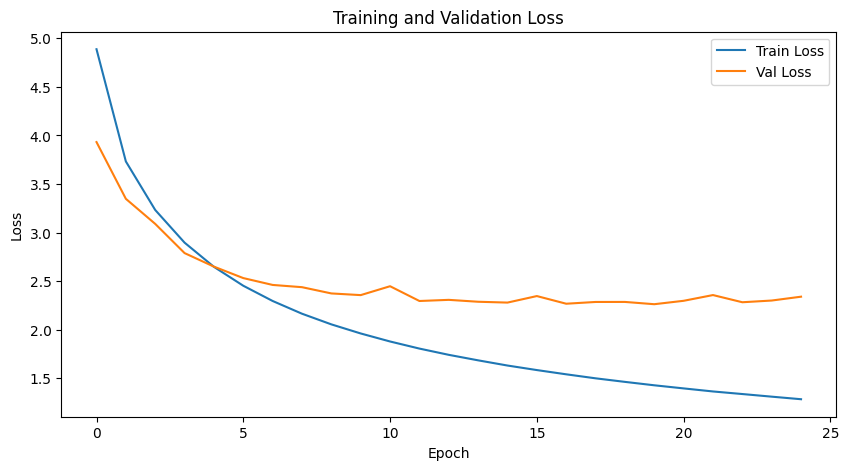

In [20]:
# Hyperparameters
EMB_DIM = 128
HIDDEN_DIM = 128
DROPOUT = 0.1
N_EPOCHS = 25
LEARNING_RATE = 0.0005
CLIP = 1.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize components with NUM_LAYERS
encoder = EncoderBiLSTM(len(pt_vocab), EMB_DIM, HIDDEN_DIM, pt_vocab.stoi[PAD_TOKEN], DROPOUT)
decoder = Decoder(len(en_vocab), EMB_DIM, HIDDEN_DIM, en_vocab.stoi[PAD_TOKEN], DROPOUT)
dec_init = DecoderInit(HIDDEN_DIM)
out_proj = OutputProjection(HIDDEN_DIM, len(en_vocab))

model = Seq2SeqNMT(encoder, decoder, dec_init, out_proj).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=en_vocab.stoi[PAD_TOKEN])

train_losses = []
val_losses = []

print(f"Training on {device}...")

for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = 0

    # Train Loop
    for src_pad, src_lens, tgt_pad, tgt_lens in tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}", leave=False):
        src_pad, tgt_pad = src_pad.to(device), tgt_pad.to(device)
        # Note: src_lens should stay on CPU for pack_padded_sequence if required by version,
        # but my EncoderBiLSTM calls .cpu() on it, so it's safe to be on any device.

        optimizer.zero_grad()

        # Forward
        logits = model(src_pad, src_lens, tgt_pad)

        # Targets are shifted by 1 (exclude BOS)
        targets = tgt_pad[:, 1:]

        # Flatten
        logits = logits.reshape(-1, logits.shape[-1])
        targets = targets.reshape(-1)

        loss = criterion(logits, targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for src_pad, src_lens, tgt_pad, tgt_lens in val_loader:
            src_pad, tgt_pad = src_pad.to(device), tgt_pad.to(device)
            logits = model(src_pad, src_lens, tgt_pad)
            targets = tgt_pad[:, 1:]

            logits = logits.reshape(-1, logits.shape[-1])
            targets = targets.reshape(-1)

            loss = criterion(logits, targets)
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### BLEU Evaluation

After training is complete, we evaluate the translation quality of the model using the **BLEU (Bilingual Evaluation Understudy)** score.

BLEU is a **corpus-level** evaluation metric for machine translation. It is computed by comparing a set of model-generated translations (*hypotheses*) against ground-truth translations (*references*). BLEU measures the overlap of n-grams (typically 1- to 4-grams) between the hypotheses and references, and applies a **brevity penalty** to discourage
overly short translations.

Importantly, BLEU is **not computed during training** and is **not differentiable**. It is used purely for evaluation.

</br>
</br>

**How BLEU is computed in this question**

1. The trained model is used to **decode full translations** for each source sentence in the **test set**, using an autoregressive decoding strategy. For this part, use beam search.
2. For each test example, the generated translation is treated as the hypothesis, and the ground-truth English sentence is treated as the reference.
3. The BLEU score is computed over the entire test set (corpus-level BLEU), and the final BLEU score is reported.


**Implement a BLEU evaluation routine** that decodes translations for the test set using beam search and computes the corpus-level BLEU score against the reference translations.

> You may use your implementation of beam search from Q1.

In [21]:
def beam_search_decode(model, src_sentence, beam_size=5, max_len=50):
    model.eval()
    with torch.no_grad():
        # Encode
        src_ids = pt_vocab.encode(src_sentence)
        # Add batch dim
        src_tensor = torch.tensor([src_ids], dtype=torch.long, device=device)
        src_len = torch.tensor([len(src_ids)], dtype=torch.long)

        enc_hiddens, (h_n, c_n) = model.encoder(src_tensor, src_len)
        h, c = model.dec_init(h_n, c_n)

        # Candidates: (score, [token_ids], (h, c))
        # Start with BOS
        candidates = [(0.0, [en_vocab.stoi[BOS_TOKEN]], (h, c))]
        completed = []

        for _ in range(max_len):
            new_candidates = []
            for score, seq, (curr_h, curr_c) in candidates:
                if seq[-1] == en_vocab.stoi[EOS_TOKEN]:
                    completed.append((score, seq))
                    continue

                inp_token = torch.tensor([seq[-1]], dtype=torch.long, device=device)

                # Decoder Step (manual expansion of Decoder logic)
                # 1. Embed
                embed = model.decoder.embedding(inp_token) # (1, E)
                embed = model.decoder.dropout(embed) # Apply dropout? Usually not in eval, but model.eval() handles it.

                # 2. LSTM
                new_h, new_c = model.decoder.lstm(embed, (curr_h, curr_c))

                # 3. Attention
                context, _ = model.decoder.attention(new_h, enc_hiddens, src_len.to(device))

                # 4. Combine
                combined = torch.cat((new_h, context), dim=1)
                attn_vec = torch.tanh(model.decoder.combine_proj(combined))

                # 5. Output Proj
                logits = model.out_proj(attn_vec)
                log_probs = F.log_softmax(logits, dim=1)

                topv, topi = log_probs.topk(beam_size)

                for v, i in zip(topv[0], topi[0]):
                    new_candidates.append((score + v.item(), seq + [i.item()], (new_h, new_c)))

            if not new_candidates:
                break

            new_candidates.sort(key=lambda x: x[0], reverse=True)
            candidates = new_candidates[:beam_size]

        if not completed:
            completed = [(c[0], c[1]) for c in candidates]

        completed.sort(key=lambda x: x[0], reverse=True)
        best_seq = completed[0][1]

        return en_vocab.decode(best_seq)

def compute_bleu(references, hypotheses):
    # Calculate BLEU-4 score
    precisions = []
    for n in range(1, 5):
        correct = 0
        total = 0
        for ref, hyp in zip(references, hypotheses):
            ref_tokens = ref.split()
            hyp_tokens = hyp.split()

            ref_counts = Counter([tuple(ref_tokens[i:i+n]) for i in range(len(ref_tokens)-n+1)])
            hyp_counts = Counter([tuple(hyp_tokens[i:i+n]) for i in range(len(hyp_tokens)-n+1)])

            for gram, count in hyp_counts.items():
                total += count
                correct += min(count, ref_counts.get(gram, 0))

        if total > 0:
            precisions.append(correct / total)
        else:
            precisions.append(0)

    if min(precisions) == 0:
        return 0.0

    geo_mean = math.exp(sum(math.log(p) for p in precisions) / 4)

    ref_len = sum(len(r.split()) for r in references)
    hyp_len = sum(len(h.split()) for h in hypotheses)

    if hyp_len > ref_len:
        bp = 1.0
    else:
        bp = math.exp(1 - ref_len / hyp_len) if hyp_len > 0 else 0

    return bp * geo_mean

# Evaluate on Test Set
print("Evaluating on Test Set...")
hypotheses = []
references = []

# Take a subset if needed, but instructions imply full test set (or what is loaded)
# We loaded test_pt and test_en (2000 examples)
for pt, en in tqdm(zip(test_pt, test_en), total=len(test_pt), desc="Decoding"):
    hyp = beam_search_decode(model, pt, beam_size=5)
    hypotheses.append(hyp)
    references.append(en)

bleu_score = compute_bleu(references, hypotheses)
print(f"Corpus-Level BLEU Score: {bleu_score*100:.2f}")

# Show some examples
print("\nExample Translations:")
for i in range(5):
    print(f"Src: {test_pt[i]}")
    print(f"Ref: {test_en[i]}")
    print(f"Hyp: {hypotheses[i]}")
    print("-" * 30)

Evaluating on Test Set...


Decoding:   0%|          | 0/1803 [00:00<?, ?it/s]

Corpus-Level BLEU Score: 28.96

Example Translations:
Src: depois , podem fazer-se e testar-se previsões .
Ref: then , predictions can be made and tested .
Hyp: and then you can become a predictions and <unk> predictions .
------------------------------
Src: forçou a parar múltiplos laboratórios que ofereciam testes brca .
Ref: it had forced multiple labs that were offering brca testing to stop .
Hyp: they took <unk> multiple labs that <unk> tests tests .
------------------------------
Src: as formigas são um exemplo clássico ; as operárias trabalham para as rainhas e vice-versa .
Ref: ants are a classic example ; workers work for queens and queens work for workers .
Hyp: ants are an classic example ; the <unk> work for <unk> and vice versa .
------------------------------
Src: uma em cada cem crianças no mundo nascem com uma doença cardíaca .
Ref: one of every hundred children born worldwide has some kind of heart disease .
Hyp: one in every hundred kids in the world are born with a h

### Understanding & Reflection Questions



Answer the following questions in your own words.  
Your answers should demonstrate conceptual understanding rather than
code-level details.

1. **Parallel Corpus Understanding**  
   What is a *parallel corpus* in machine translation?  
   In this assignment, what constitutes a single training example, and why is this format appropriate for NMT?
   
   <span style="color:red">A parallel corpus is a dataset consisting of texts in one language aligned with their translations in another language. In this assignment, a single training example constitutes a pair of sentences: one in Portuguese (source) and its corresponding translation in English (target). This format provides the direct supervision needed for the model to learn the mapping from the source language domain to the target language domain.</span>

2. **Vocabulary & Special Tokens**  
   Which special tokens are required for training and decoding (e.g., `<pad>`, `<unk>`, `<sos>`, `<eos>`)?  
   Explain the role of each token in **both** training (teacher forcing) and inference (decoding).
   
   <span style="color:red">
   *   `<pad>`: Used to fill shorter sequences to match batch length. Ignored during training loss and inference.
   *   `<unk>`: Represents unknown words not in the vocabulary, allowing the model to handle out-of-vocabulary terms gracefully.
   *   `<bos>` (or `<sos>`): Start-of-sentence. In training, it's the first input to the decoder. In inference, it initializes the decoding process.
   *   `<eos>`: End-of-sentence. In training, it marks the end of the target. In inference, the model generates this to signal it has finished the translation.
   </span>

3. **Encoder–Decoder Interface**  
   Our encoder is a **bidirectional** LSTM while our decoder is **unidirectional**.  
   Explain why this creates a mismatch in the final states, and how we resolve it to initialize the decoder.
   
   <span style="color:red">A bidirectional LSTM produces two final hidden states (one for forward, one for backward), effectively doubling the hidden state dimension (or count) compared to a unidirectional LSTM of the same size. The decoder is unidirectional and expects a single hidden state vector. We resolve this mismatch by concatenating the forward and backward encoder states and passing them through a linear projection layer (often with a non-linearity like tanh) to compress/transform them into the shape required to initialize the decoder's hidden state.</span>

4. **Attention Mechanism (High-level)**  
   What problem does attention solve in neural machine translation?  
   Describe (in words) how the decoder uses attention at a single timestep to choose which source positions to focus on.
   
   <span style="color:red">Attention solves the "information bottleneck" problem where the encoder must compress the entire source sentence into a single fixed-length vector. At each timestep, the decoder uses its current hidden state to compute a relevance score for every encoder hidden state (source word). These scores are normalized into probabilities (weights). The decoder then calculates a weighted sum of the encoder states (context vector), effectively "focusing" on the most relevant parts of the source sentence to help generate the next word.</span>

5. **Training vs. Decoding**  
   During training we use teacher forcing, but at test time the model must generate translations autoregressively.  
   Explain the difference between these two settings, and describe one potential consequence of this mismatch.
   
   <span style="color:red">**Training (Teacher Forcing):** The model is fed the *ground-truth* previous token as input for the current step, regardless of what it predicted.
   **Decoding (Autoregressive):** The model is fed its *own predicted* token from the previous step as input.
   **Consequence:** This creates "exposure bias." The model may become reliant on perfect inputs during training and fail to recover from its own errors during inference, leading to compounding errors as generation proceeds.</span>

6. **BLEU Interpretation**  
   What does BLEU measure at a high level, and why is it computed at the **corpus level** rather than per sentence?  
   Briefly explain how the decoding strategy (greedy vs. beam search) can affect BLEU.
   
   <span style="color:red">BLEU measures the n-gram overlap (precision) between the generated translation and reference translations, penalized for brevity. It is computed at the corpus level to provide a statistically robust metric, as n-gram matches for individual sentences can be sparse and noisy. Beam search typically yields higher BLEU scores than greedy decoding because it explores multiple valid paths to find a sequence with higher overall probability, often resulting in more coherent and grammatical translations that better match the references.</span>
   
7. **Length Effects**  
   In practice, how does translation quality tend to change as sentence length increases?  
   Give one reason why longer sentences are harder for sequence-to-sequence models.
   
   <span style="color:red">Translation quality generally degrades as sentence length increases. One reason is that the fixed-size context vector (in non-attention models) cannot capture all information from a long sequence. Even with attention, long-range dependencies become harder to model, and the attention mechanism might become "distracted" or unfocused over very long sequences, leading to repetitions or omissions.</span>
